<a href="https://colab.research.google.com/github/itsfaryar/Meta-Learning-for-Human-Sperm-Abnormality-Detection/blob/main/Local_Meta-Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries & Constants**

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
# download qpth package and fix the bug in setup.py then install it
# !wget https://github.com/amirezzati/Meta-Learning-for-Human-Sperm-Abnormality-Detection/raw/main/Requirements/qpth-0.0.15.tar.gz
# !tar -xzvf qpth-0.0.15.tar.gz
# !python qpth-0.0.15/setup.py install

In [ ]:
# !pip install learn2learn

In [ ]:
from tqdm import tqdm
import random

import learn2learn as l2l
import torch
import torchvision
from torch import nn, optim
from torch.optim import Optimizer, Adam
from torch.utils.data import DataLoader, Dataset, Sampler
from torch.utils.data import SubsetRandomSampler, ConcatDataset
from torch.utils.data import random_split
from torchvision.io import read_image
from torchvision import transforms as t
from torchvision.transforms import functional as F

# cross-validaion and evaluation tools
from sklearn.metrics import classification_report
from sklearn import metrics

import cv2
import pandas as pd
import tensorflow as tf
import numpy as np
import PIL
from matplotlib import pyplot as plt
import os
from copy import deepcopy
#from google.colab import drive

from typing import Callable, Union
from collections import OrderedDict

from tqdm import trange
import time

In [ ]:
# drive.mount('/content/drive')
# #data_path = "/content/drive/MyDrive/AI Projects/Meta-learning vision project/mhsma-dataset sperm images/mhsma/"
# data_path = "/content/drive/MyDrive/AI Projects/mhsma-dataset/mhsma/"
data_path = "/home/mokaddar/Documents/notebook/mhsma-dataset/mhsma/"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


In [ ]:
path_vgg19_bn = "/home/mokaddar/Documents/notebook/models/vgg19_bn-c79401a0.pth"


# **Preprocessing**

In [ ]:
class DatasetPair(Dataset):
  def __init__(self, x, y, transform=None, target_transform=None):
    self.img_labels = y
    self.imgs = x
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    image = self.imgs[idx]
    label = self.img_labels[idx]
    # if self.transform:
    #     image = self.transform(image)
    # if self.target_transform:
    #     label = self.target_transform(label)
    return image, label

In [ ]:
# import dataset from path
threeChannelImg = lambda x: np.stack((x, x, x), axis=0)

def constructDataset(data_shape=64, target_type='head', channel_size=3,normalization="vgg",  goal_size = 224):
  # --------- Load datasets -----------
  x_train = np.load(data_path + 'x_'+str(data_shape)+'_train.npy')
  x_dev = np.load(data_path + 'x_'+str(data_shape)+'_valid.npy')
  x_test = np.load(data_path + 'x_'+str(data_shape)+'_test.npy')

  if target_type == 'acrosome':
    y_train = np.load(data_path + 'y_acrosome_train.npy')
    y_dev = np.load(data_path + 'y_acrosome_valid.npy')
    y_test = np.load(data_path + 'y_acrosome_test.npy')

  elif target_type == 'head':
    y_train = np.load(data_path + 'y_head_train.npy')
    y_dev = np.load(data_path + 'y_head_valid.npy')
    y_test = np.load(data_path + 'y_head_test.npy')

  elif target_type == 'tail':
    y_train = np.load(data_path + 'y_tail_train.npy')
    y_dev = np.load(data_path + 'y_tail_valid.npy')
    y_test = np.load(data_path + 'y_tail_test.npy')

  elif target_type == 'vacuole':
    y_train = np.load(data_path + 'y_vacuole_train.npy')
    y_dev = np.load(data_path + 'y_vacuole_valid.npy')
    y_test = np.load(data_path + 'y_vacuole_test.npy')



  # --------- Preprocess datasets -----------
  if channel_size == 3:
    x_train = np.array([threeChannelImg(sample) for sample in x_train], dtype=np.float32)
    x_test = np.array([threeChannelImg(sample) for sample in x_test], dtype=np.float32)
    x_dev = np.array([threeChannelImg(sample) for sample in x_dev], dtype=np.float32)

  print('x_train.shape: ', x_train.shape)
  print('x_dev.shape: ', x_dev.shape)
  print('x_test.shape: ', x_test.shape)
  print('y_acrosome_train.shape: ', y_train.shape) # y = 1 abnormal,  y = 0 normal
  #normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
  #                               std=[0.229, 0.224, 0.225])
  # conver x and y to torch tensor
  # x_train_tensor = normalize(torch.from_numpy(x_train))
  # x_test_tensor = normalize(torch.from_numpy(x_test))
  # x_dev_tensor = normalize(torch.from_numpy(x_dev))


  vgg_preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Pad(((goal_size-data_shape)//2,(goal_size-data_shape)//2), fill=0, padding_mode='constant'),
    torchvision.transforms.Lambda(lambda x: x.float()),
    torchvision.transforms.Lambda(lambda x: x.div(255.0)),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
  ])


  x_train_tensor = torch.from_numpy(x_train)
  x_test_tensor = torch.from_numpy(x_test)
  x_dev_tensor = torch.from_numpy(x_dev)

  if normalization=="vgg":
    x_train_tensor = vgg_preprocess(x_train_tensor)
    x_test_tensor  = vgg_preprocess(x_test_tensor)
    x_dev_tensor   = vgg_preprocess(x_dev_tensor)

  y_train_tensor = torch.from_numpy(y_train)
  y_test_tensor = torch.from_numpy(y_test)
  y_dev_tensor = torch.from_numpy(y_dev)

  # create Dataset class for each sets
  trainset = DatasetPair(x_train_tensor, y_train_tensor)
  devset = DatasetPair(x_dev_tensor, y_dev_tensor)
  testset = DatasetPair(x_test_tensor, y_test_tensor)

  return trainset, devset, testset

def preprocessImages(img):
  #brightness = -150
  # Adjusts the contrast by scaling the pixel values by 2.3
  #contrast = 2.9
  #out=np.zeros(img.shape, img.dtype)

  #out = cv2.addWeighted(img, contrast, np.zeros(img.shape, img.dtype), 0, brightness)
  #out =  cv2.normalize(out,   np.zeros(img.shape, img.dtype), 0, 255, cv2.NORM_MINMAX)
  #out = cv2.Canny(out, 55, 110)
  #out = cv2.resize(out, (size, size))
  return img

In [ ]:
trainset, devset, testset = constructDataset(data_shape=128, target_type='head')

print('--'*20 + '\n' + 'each image size: ', trainset[0][0].shape)
print('each label size: ', trainset[0][1].shape)

x_train.shape:  (1000, 3, 128, 128)
x_dev.shape:  (240, 3, 128, 128)
x_test.shape:  (300, 3, 128, 128)
y_acrosome_train.shape:  (1000,)
----------------------------------------
each image size:  torch.Size([3, 224, 224])
each label size:  torch.Size([])


Example

In [ ]:
def show(dataset, N=5, labels=None, figsize=(20, 20)):
    """ Shows random N samples from the dataset """
    idxs = np.random.randint(0, len(dataset)-1, N)

    fig, axs = plt.subplots(ncols=len(idxs), squeeze=False, figsize=figsize)

    for i, idx in enumerate(idxs):
        sample = dataset[idx]
        if isinstance(sample, tuple): # then it is in the form (x, y)
          sample, label = sample

          if isinstance(label, torch.Tensor):
            label = int(label.item())
          if labels:
            label = labels[label]
          axs[0, i].title.set_text(label)
        # print(threeChannelImg(sample).shape)
        axs[0, i].imshow(sample.type(torch.int16).permute(1, 2, 0))
        axs[0, i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

    plt.show()

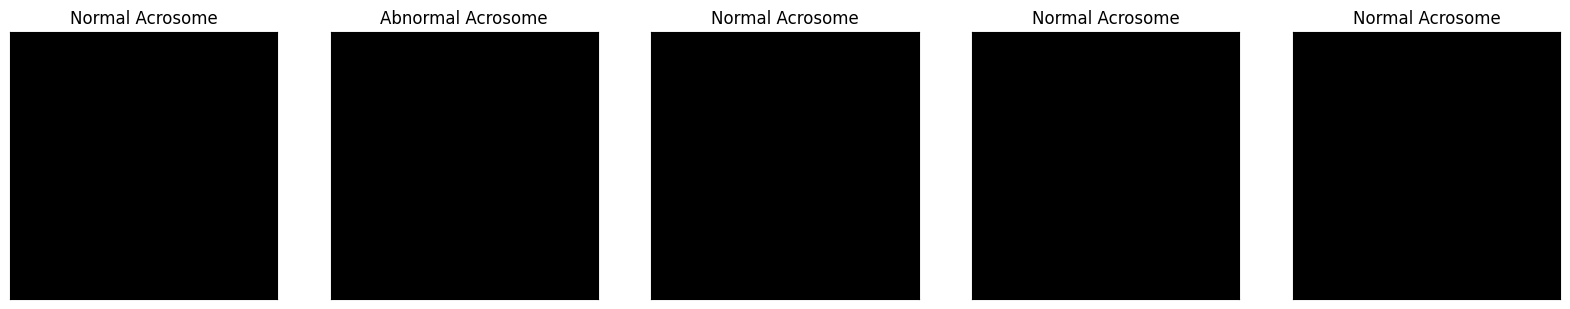

In [ ]:
idx_to_labels = {0: "Normal Acrosome", 1: "Abnormal Acrosome"}
show(trainset, labels=idx_to_labels)

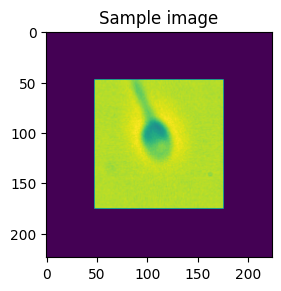

In [ ]:
image = trainset.imgs[1][0]
plt.subplot(1, 2, 2)
plt.title("Sample image")
plt.imshow(image)
plt.show()

# **MAML Implementation**

In [ ]:
class NShotTaskSampler(Sampler):
    def __init__(self,
                 dataset: torch.utils.data.Dataset,
                 episodes_per_epoch: int = None,
                 n: int = None,
                 k: int = None,
                 q: int = None,
                 num_tasks: int = 1):

        """PyTorch Sampler subclass that generates batches of n-shot, k-way,
        q-query tasks.

        Each n-shot task contains a "support set" of `k` sets of `n` samples and
        a "query set" of `k` sets of `q` samples. The support set and the query set
        are all grouped into one Tensor such that the first n * k samples are from
        the support set while the remaining q * k samples are from the query set.

        The support and query sets are sampled such that they are disjoint
        i.e. do not contain overlapping samples.

        # Arguments
            dataset: Instance of torch.utils.data.Dataset from which to draw samples
            episodes_per_epoch: Arbitrary number of batches of n-shot tasks to
                                generate in one epoch
            n_shot: int. Number of samples for each class in the n-shot
                            classification tasks.
            k_way: int. Number of classes in the n-shot classification tasks.
            q_queries: int. Number query samples for each class in the n-shot
                            classification tasks.
            num_tasks: Number of n-shot tasks to group into a single batch
        """
        super(NShotTaskSampler, self).__init__(dataset)
        self.episodes_per_epoch = episodes_per_epoch
        self.dataset = dataset
        if num_tasks < 1:
            raise ValueError('num_tasks must be > 1.')

        self.num_tasks = num_tasks
        # TODO: Raise errors if initialise badly
        self.k = k
        self.n = n
        self.q = q

    def __len__(self):
        return self.episodes_per_epoch

    def __iter__(self):
        for _ in range(self.episodes_per_epoch):
            batch = []

            for task in range(self.num_tasks):
                # Get random classes

                episode_classes = np.unique(self.dataset.img_labels, return_counts=False)

                for k in episode_classes:
                    support_ids = np.random.choice(np.where(self.dataset.img_labels == k)[0], size=self.n)
                    # print(support_ids)

                    for x in support_ids:
                        batch.append(x)

                for k in episode_classes:
                    query=np.setdiff1d(np.where(self.dataset.img_labels == k)[0], support_ids)
                    query = query[np.random.choice(query.shape[0], self.q, replace=False)]

                    for x in query:
                        batch.append(x)

            yield np.stack(batch)

In [ ]:
def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)

def fast_adapt(batch, learner, loss, adaptation_steps, shots, ways, device):
    data, labels = batch
    data, labels = data.to(device), labels.to(device)

    # Separate data into adaptation/evalutation sets
    adaptation_indices = np.zeros(data.size(0), dtype=bool)
    adaptation_indices[np.arange(shots*ways) * 2] = True
    #print(adaptation_indices)
    evaluation_indices = torch.from_numpy(~adaptation_indices)
    adaptation_indices = torch.from_numpy(adaptation_indices)
    adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
    evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]

    # Adapt the model
    for step in range(adaptation_steps):
      adaptation_data = adaptation_data.to(torch.float)
      # print(adaptation_labels.shape)
      train_error = loss(learner(adaptation_data), adaptation_labels)
      learner.adapt(train_error)

    # Evaluate the adapted model
    predictions = learner(evaluation_data.to(torch.float))
    valid_error = loss(predictions, evaluation_labels)
    valid_accuracy = accuracy(predictions, evaluation_labels)
    return valid_error, valid_accuracy


def maml_train(trainset, devset, testset,
              base_model,
              MAML_path,
              ways=2,
              shots=10,
              meta_lr=0.0001,#0.003
              fast_lr=0.001,#0.5
              meta_batch_size=32,#32
              adaptation_steps=5,
              num_iterations=100,#60000
              cuda=True,
              seed=42,
              ):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    device = torch.device('cpu')

    if cuda:
      torch.cuda.manual_seed(seed)
      device = torch.device('cuda')


    epoch_len = meta_batch_size
    train_taskloader = DataLoader(trainset,
                                  batch_sampler=NShotTaskSampler(trainset, epoch_len, n=2*shots,
                                                                  k=ways, q=0,
                                                                  num_tasks=1),
                                  num_workers=1
    )
    dev_taskloader = DataLoader(devset,
                                batch_sampler=NShotTaskSampler(devset, epoch_len, n=0,
                                                                k=ways, q=2*shots,
                                                                num_tasks=1),
                                num_workers=1
    )
    test_taskloader = DataLoader(testset,
                                batch_sampler=NShotTaskSampler(testset, epoch_len, n=0,
                                                                k=ways, q=2*shots,
                                                                num_tasks=1),
                                num_workers=1
    )

    # Create model
    # model = l2l.vision.models.CNN4(output_size=ways, hidden_size=128, channels=3, embedding_size=2048) #l2l.vision.models.OmniglotFC(128 * 128, ways)#CIFAR10Model()
    # model = l2l.vision.models.WRN28(output_size=ways, hidden_size=128)
    # model = CIFAR10Model()
    # model = ConvNetBinaryClassification()
    # model  = VGG11BinaryClassification()
    model = base_model
    # model  = VGG16Simple()

    model.to(device)
    maml = l2l.algorithms.MAML(model, lr=fast_lr, first_order=False, allow_nograd=True)
    opt = optim.Adam(filter(lambda p: p.requires_grad, maml.parameters()), meta_lr) #optim.Adam(maml.parameters(), meta_lr)
    loss = nn.CrossEntropyLoss(reduction='mean')

    best_valid_loss = float('inf')
    best_valid_acc = 0
    for iteration in range(num_iterations):
        opt.zero_grad()
        meta_train_error = 0.0
        meta_train_accuracy = 0.0
        meta_valid_error = 0.0
        meta_valid_accuracy = 0.0
        for train_batch, val_batch in zip(train_taskloader, dev_taskloader): # epoch_len     #range(meta_batch_size):
            # Compute meta-training loss
            learner = maml.clone()

            evaluation_error, evaluation_accuracy = fast_adapt(train_batch,
                                                                learner,
                                                                loss,
                                                                adaptation_steps,
                                                                shots,
                                                                ways,
                                                                device)

            evaluation_error.backward()
            meta_train_error += evaluation_error.item()
            meta_train_accuracy += evaluation_accuracy.item()

            # Compute meta-validation loss
            learner = maml.clone()

            evaluation_error, evaluation_accuracy = fast_adapt(val_batch,
                                                               learner,
                                                               loss,
                                                               adaptation_steps,
                                                               shots,
                                                               ways,
                                                               device)
            meta_valid_error += evaluation_error.item()
            meta_valid_accuracy += evaluation_accuracy.item()

            if meta_valid_accuracy > best_valid_acc: #meta_valid_error < best_valid_loss:
              best_valid_acc = meta_valid_accuracy
              torch.save(learner, MAML_path)

        # Print some metrics
        # if (iteration+1) % 5 == 0:
        print('\n')
        print('Iteration', iteration)
        print('Meta Train Error', meta_train_error / meta_batch_size)
        print('Meta Train Accuracy', meta_train_accuracy / meta_batch_size)
        print('Meta Valid Error', meta_valid_error / meta_batch_size)
        print('Meta Valid Accuracy', meta_valid_accuracy / meta_batch_size)

        # Average the accumulated gradients and optimize
        for p in maml.parameters():
          if p.requires_grad:
            p.grad.data.mul_(1.0 / meta_batch_size)
        opt.step()

    meta_test_error = 0.0
    meta_test_accuracy = 0.0
    for test_batch in test_taskloader:
        # Compute meta-testing loss
        learner = maml.clone()

        evaluation_error, evaluation_accuracy = fast_adapt(test_batch,
                                                           learner,
                                                           loss,
                                                           adaptation_steps,
                                                           shots,
                                                           ways,
                                                           device)
        meta_test_error += evaluation_error.item()
        meta_test_accuracy += evaluation_accuracy.item()
    print('Meta Test Error', meta_test_error / meta_batch_size)
    print('Meta Test Accuracy', meta_test_accuracy / meta_batch_size)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **MAML on Head Target**

x_train.shape:  (1000, 3, 128, 128)
x_dev.shape:  (240, 3, 128, 128)
x_test.shape:  (300, 3, 128, 128)
y_acrosome_train.shape:  (1000,)
----------------------------------------
each image size:  torch.Size([3, 224, 224])
each label size:  torch.Size([])


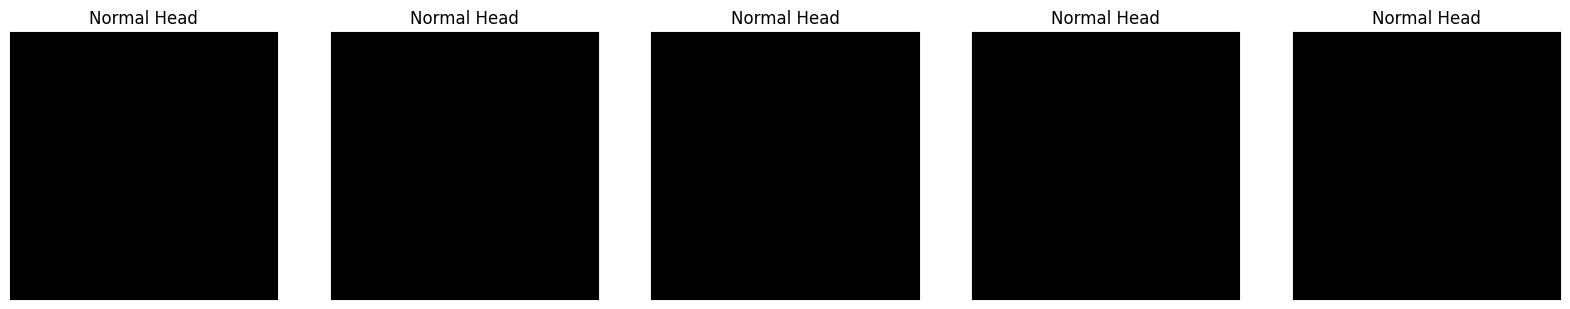

In [ ]:
trainset, devset, testset = constructDataset(data_shape=128, target_type='head')
print('--'*20 + '\n' + 'each image size: ', trainset.imgs[0].shape)
print('each label size: ', trainset.img_labels[0].shape)

idx_to_labels = {0: "Normal Head", 1: "Abnormal Head"}
show(trainset, labels=idx_to_labels)

In [ ]:
class CNN4PLUS(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        # self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.conv3 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1)
        self.act3 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.bn1 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1)
        self.act4 = nn.ReLU()
        self.conv5 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1)
        self.act5 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.bn2 = nn.BatchNorm2d(128)

        self.conv6 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1)
        self.act6 = nn.ReLU()
        self.conv7 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1)
        self.act7 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))
        self.bn3 = nn.BatchNorm2d(128)


        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(32768, 256) # 131072 6272
        self.actf = nn.ReLU()
        # self.drop3 = nn.Dropout(0.5)

        #self.fc4 = nn.Linear(256, 64)

        self.fc5 = nn.Linear(256, 2)
        self.actf2 = nn.Sigmoid()

    def forward(self, x):
        # input 1x128x128, output 32x32x32
        x = self.act1(self.conv1(x))
        # x = self.drop1(x)
        # x = self.pool(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        # x = self.pool(x)

        x = self.act3(self.conv3(x))
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.act4(self.conv4(x))
        x = self.act5(self.conv5(x))
        # x = self.pool2(x)
        x = self.bn2(x)
        x = self.act6(self.conv6(x))
        x = self.act7(self.conv7(x))
        # x = self.pool3(x)
        x = self.bn3(x)
        # input 32x32x32, output 32x16x16
        #x = self.pool3(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.actf(self.fc3(x))
        # x = self.drop3(x)
        # input 512, output 10
        #x = self.fc4(x)

        x = self.fc5(x)
        # x = self.act5(x)
        return x

In [ ]:
class VGG16BinaryClassification(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torchvision.models.vgg16(pretrained=True)
        self.model.classifier[6] = nn.Linear(4096, 2)

        unfreeze = ['classifier']
        for layer_name, layer in self.model.named_parameters():
            for name in unfreeze:
                if name in layer_name:
                    layer.requires_grad = True
                    break
                else:
                    layer.requires_grad = False

    def forward(self, x):
        return self.model(x)


class VGG19BinaryClassification(nn.Module):
    def __init__(self,freeze=False):
        super().__init__()

        self.model = models.vgg19_bn(pretrained=False)
        self.model.load_state_dict(torch.load(path_vgg19_bn))
        self.model.classifier[6] = nn.Linear(4096, 2)
        if freeze:
          unfreeze = ['classifier']
          for layer_name, layer in self.model.named_parameters():
              for name in unfreeze:
                  if name in layer_name:
                      layer.requires_grad = True
                      break
                  else:
                      layer.requires_grad = False

    def forward(self, x):
        return self.model(x)
class VGG19BinaryClassification_custom1(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torchvision.models.vgg19_bn(pretrained=True)
        self.model.avgpool = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.AdaptiveAvgPool2d(output_size=(7, 7))
        )
        num_ftrs = self.model.classifier[0].in_features
        # self.model.classifier = nn.Sequential(
        #    # nn.Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        #    # nn.ReLU(inplace=True),
        #     nn.Linear(in_features=25088, out_features=4096, bias=True),
        #     nn.ReLU(inplace=True),
        #     nn.Dropout(p=0.5, inplace=False),
        #     nn.Linear(in_features=4096, out_features=4096, bias=True),
        #     nn.ReLU(inplace=True),
        #     nn.Dropout(p=0.5, inplace=False),
        #     nn.Linear(in_features=4096, out_features=2, bias=True)
        # )
        self.model.classifier[6] = nn.Linear(4096, 2)
        unfreeze = ['classifier','avgpool']
        for layer_name, layer in self.model.named_parameters():
            for name in unfreeze:
                if name in layer_name:
                    layer.requires_grad = True
                    break
                else:
                    layer.requires_grad = False

    def forward(self, x):
        return self.model(x)

class VGG11BinaryClassification(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torchvision.models.vgg11_bn(pretrained=True)
        # print(self.model.features)
        self.model.classifier[6] = nn.Linear(4096, 2)

        unfreeze = ['classifier']
        for layer_name, layer in self.model.named_parameters():
            for name in unfreeze:
                if name in layer_name:
                    layer.requires_grad = True
                    break
                else:
                    layer.requires_grad = False

    def forward(self, x):
        return self.model(x)

In [ ]:
# model = VGG19BinaryClassification_custom1()
# model

In [ ]:
class VGG16Simple(nn.Module):
  def __init__(self):
    super().__init__()

    self.layers = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
      nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
      nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
      nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
      nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
      nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
      nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )

    self.avgpool = nn.Flatten()

    self.classifier = nn.Sequential(
      nn.Linear(in_features=4096, out_features=1024, bias=True),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5, inplace=False),
      nn.Linear(in_features=1024, out_features=256, bias=True),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.2, inplace=False),
      nn.Linear(in_features=256, out_features=2, bias=True)
    )

  def forward(self, x):
    # forward pass
    x = self.layers(x) #torch.sigmoid(self.classifier(self.avgpool(self.layers(x))))
    return x


**On MHSMA dataset**

In [ ]:
#MAML_path = "/content/drive/MyDrive/AI Projects/Meta-learning vision project/MAML.pt"
#MAML_path = "/content/drive/MyDrive/AI Projects/mhsma-dataset/MAML.pt"

MAML_path = "/home/mokaddar/Documents/notebook/faryar/Meta-Learning-for-Human-Sperm-Abnormality-Detection/models/MAML_128_vgg19_.pt"

In [ ]:
maml_train(trainset, devset, testset, MAML_path=MAML_path, meta_lr=0.0003, fast_lr=0.01, adaptation_steps=5, num_iterations=100, base_model=VGG19BinaryClassification())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 89.4MB/s]




Iteration 0
Meta Train Error 1.0342827662825584
Meta Train Accuracy 0.5000000009313226
Meta Valid Error 1.0418354626744986
Meta Valid Accuracy 0.5


Iteration 1
Meta Train Error 0.7111051250249147
Meta Train Accuracy 0.5406250106170774
Meta Valid Error 0.7350324802100658
Meta Valid Accuracy 0.5125000132247806


Iteration 2
Meta Train Error 0.6988417990505695
Meta Train Accuracy 0.5546875121071935
Meta Valid Error 0.7078053150326014
Meta Valid Accuracy 0.5140625108033419


Iteration 3
Meta Train Error 0.6803312450647354
Meta Train Accuracy 0.5906250085681677
Meta Valid Error 0.6949827298521996
Meta Valid Accuracy 0.530468761920929


Iteration 4
Meta Train Error 0.687734954059124
Meta Train Accuracy 0.5593750094994903
Meta Valid Error 0.693681463599205
Meta Valid Accuracy 0.528125012293458


Iteration 5
Meta Train Error 0.6771835144609213
Meta Train Accuracy 0.5742187649011612
Meta Valid Error 0.6912569031119347
Meta Valid Accuracy 0.5359375048428774


Iteration 6
Meta Train Error 0.65

In [ ]:
model = torch.load(MAML_path)
model.eval()

MAML(
  (module): VGG11BinaryClassification(
    (model): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU(inplace=True)
        (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (10): ReLU(inplace=True)
        (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (12): BatchNorm2d(256, e

**Result on trainset**

In [ ]:
# # print(testset.imgs.shape)
# train_pred = model(trainset.imgs.type(torch.cuda.FloatTensor))
# train_pred.shape, accuracy(train_pred, trainset.img_labels.to(torch.device('cuda')))

**Result on devtset**

In [ ]:
# print(testset.imgs.shape)
dev_pred = model(devset.imgs.type(torch.cuda.FloatTensor))
dev_pred.shape, accuracy(dev_pred, devset.img_labels.to(torch.device('cuda')))

(torch.Size([240, 2]), tensor(0.7125, device='cuda:0'))

**Result on testset**

In [ ]:
# print(testset.imgs.shape)
test_pred = model(testset.imgs.type(torch.cuda.FloatTensor))
test_pred.shape, accuracy(test_pred, testset.img_labels.to(torch.device('cuda')))

(torch.Size([300, 2]), tensor(0.7033, device='cuda:0'))